# Flu Shot Learning

The goal of this notebook is to predict the whether each of a group of individuals have received two types of flu vaccines using a number of different relevant features.

This project is part of the [Flu Shot Learning competition](https://www.drivendata.org/competitions/66/flu-shot-learning/) by Driven Data.

The data for this competition comes from the National 2009 H1N1 Flu Survey (NHFS).  In their own words:

>The National 2009 H1N1 Flu Survey (NHFS) was sponsored by the National Center for Immunization and Respiratory Diseases (NCIRD) and conducted jointly by NCIRD and the National Center for Health Statistics (NCHS), Centers for Disease Control and Prevention (CDC). The NHFS was a list-assisted random-digit-dialing telephone survey of households, designed to monitor influenza immunization coverage in the 2009-10 season.
>
>The target population for the NHFS was all persons 6 months or older living in the United States at the time of the interview. Data from the NHFS were used to produce timely estimates of vaccination coverage rates for both the monovalent pH1N1 and trivalent seasonal influenza vaccines.
     
[<cite>National 2009 H1N1 Flu Survey (NHFS) Public-Use Data File (PUF)</cite>](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/nis/nhfs/nhfspuf_readme.txt)

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('dark')

# Read data

Training data are stored in 2 separate files, one with the features and one with the labels for each entry.

In [2]:
def get_data(feat_path, label_path=''):
    df_X = pd.read_csv(feat_path)
    df_X.set_index('respondent_id', inplace=True)
    nominals = [col for col in df_X.columns if df_X[col].nunique() == 2] + [
        'race', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
    ordinals = [col for col in df_X.columns if col not in nominals]
    age_cat = pd.api.types.CategoricalDtype(['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'],
                                           ordered=True)
    college_cat = pd.api.types.CategoricalDtype(['< 12 Years', '12 Years', 'Some College', 'College Graduate'], ordered=True)
    income_cat = pd.api.types.CategoricalDtype(['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'], ordered=True)
    df_X['age_group'] = df_X['age_group'].astype(age_cat)
    df_X['education'] = df_X['education'].astype(college_cat)
    df_X['income_poverty'] = df_X['income_poverty'].astype(income_cat)
    for col in ordinals:
        if col not in ['age_group', 'education', 'income_poverty']:
            df_X[col] = df_X[col].astype(pd.api.types.CategoricalDtype([1., 2., 3., 4., 5.], ordered=True))
            df_X[col] = df_X[col].cat.remove_unused_categories()
    for col in nominals:
        df_X[col] = df_X[col].astype('category')
    ret = [df_X]
    if label_path != '':
        df_Y = pd.read_csv(label_path)
        df_Y.set_index('respondent_id', inplace=True)
        df_Y = df_Y.astype(bool)
        ret.append(df_Y)
    return ret

In [3]:
X, Y = get_data('data/training_set_features.csv', 'data/training_set_labels.csv')

In [4]:
X

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",NaN,NaN,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,NaN,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,NaN,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,NaN,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN,NaN,NaN


In [5]:
Y

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,False,False
1,False,True
2,False,False
3,False,True
4,False,False
...,...,...
26702,False,False
26703,False,False
26704,False,True


In [6]:
flushot_df = pd.concat([X, Y], axis='columns')
flushot_df.sample(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
7242,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Own,Unemployed,atmpeygn,Non-MSA,1.0,NaN,NaN,NaN,False,False
22445,3.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Own,Not in Labor Force,atmpeygn,Non-MSA,1.0,NaN,NaN,NaN,True,True
17187,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Not in Labor Force,dqpwygqj,"MSA, Not Principle City",2.0,NaN,NaN,NaN,False,False
20711,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Own,Employed,kbazzjca,"MSA, Principle City",1.0,NaN,ldnlellj,kldqjyjy,False,False
11784,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Own,Employed,lzgpxyit,"MSA, Principle City",1.0,NaN,ldnlellj,xzmlyyjv,True,True


# Exploratory data analysis -- Feature engineering

In [7]:
flushot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   h1n1_concern                 23319 non-null  category
 1   h1n1_knowledge               24085 non-null  category
 2   behavioral_antiviral_meds    26636 non-null  category
 3   behavioral_avoidance         26499 non-null  category
 4   behavioral_face_mask         26688 non-null  category
 5   behavioral_wash_hands        26665 non-null  category
 6   behavioral_large_gatherings  26620 non-null  category
 7   behavioral_outside_home      26625 non-null  category
 8   behavioral_touch_face        26579 non-null  category
 9   doctor_recc_h1n1             24547 non-null  category
 10  doctor_recc_seasonal         24547 non-null  category
 11  chronic_med_condition        25736 non-null  category
 12  child_under_6_months         25887 non-null  category
 13  h

In [8]:
flushot_df.nunique()

h1n1_concern                    3
h1n1_knowledge                  2
behavioral_antiviral_meds       2
behavioral_avoidance            2
behavioral_face_mask            2
behavioral_wash_hands           2
behavioral_large_gatherings     2
behavioral_outside_home         2
behavioral_touch_face           2
doctor_recc_h1n1                2
doctor_recc_seasonal            2
chronic_med_condition           2
child_under_6_months            2
health_worker                   2
health_insurance                2
opinion_h1n1_vacc_effective     5
opinion_h1n1_risk               5
opinion_h1n1_sick_from_vacc     5
opinion_seas_vacc_effective     5
opinion_seas_risk               5
opinion_seas_sick_from_vacc     5
age_group                       5
education                       4
race                            4
sex                             2
income_poverty                  3
marital_status                  2
rent_or_own                     2
employment_status               3
hhs_geo_region

In [9]:
for col in flushot_df.columns:
    if flushot_df[col].nunique() > 2:
        display(flushot_df[col].value_counts())

2.0    10575
1.0     8153
3.0     4591
Name: h1n1_concern, dtype: int64

4.0    11683
5.0     7166
3.0     4723
2.0     1858
1.0      886
Name: opinion_h1n1_vacc_effective, dtype: int64

2.0    9919
1.0    8139
4.0    5394
5.0    1750
3.0    1117
Name: opinion_h1n1_risk, dtype: int64

2.0    9129
1.0    8998
4.0    5850
5.0    2187
3.0     148
Name: opinion_h1n1_sick_from_vacc, dtype: int64

4.0    11629
5.0     9973
2.0     2206
1.0     1221
3.0     1216
Name: opinion_seas_vacc_effective, dtype: int64

2.0    8954
4.0    7630
1.0    5974
5.0    2958
3.0     677
Name: opinion_seas_risk, dtype: int64

1.0    11870
2.0     7633
4.0     4852
5.0     1721
3.0       94
Name: opinion_seas_sick_from_vacc, dtype: int64

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64

1.0    14474
2.0     2803
3.0     1125
Name: household_adults, dtype: int64

1.0    3175
2.0    2864
3.0    1747
Name: household_children, dtype: int64

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

In [10]:
for col in flushot_df.columns:
    if flushot_df[col].nunique() == 2:
        display(flushot_df[col].value_counts())

1.0    14598
2.0     9487
Name: h1n1_knowledge, dtype: int64

0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64

1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64

0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64

1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64

0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64

0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64

1.0    18001
0.0     8578
Name: behavioral_touch_face, dtype: int64

0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64

0.0    16453
1.0     8094
Name: doctor_recc_seasonal, dtype: int64

0.0    18446
1.0     7290
Name: chronic_med_condition, dtype: int64

0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64

0.0    23004
1.0     2899
Name: health_worker, dtype: int64

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

Female    15858
Male      10849
Name: sex, dtype: int64

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

False    21033
True      5674
Name: h1n1_vaccine, dtype: int64

False    14272
True     12435
Name: seasonal_vaccine, dtype: int64

### Observations
1. There are several missing values
2. All features are categorical
3. Features with cardinality greater than 2, except `race`, `employment_status`, `hhs_geo_region`, `census_msa`, `employment_industry` and `employment_occupation` are ordinal categoricals.  All binary features, and `race`, `employment_status`, `hhs_geo_region`, `census_msa`, `employment_industry` and `employment_occupation` are nominal categoricals.

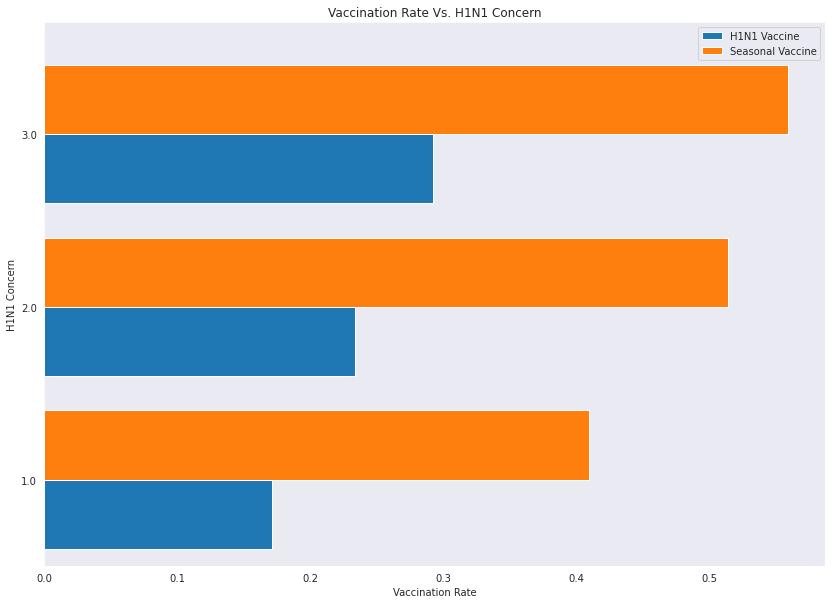

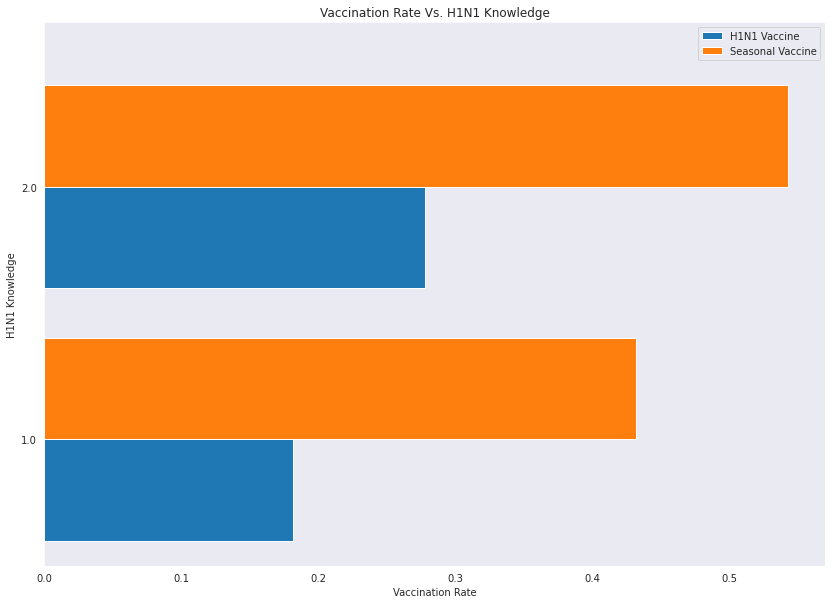

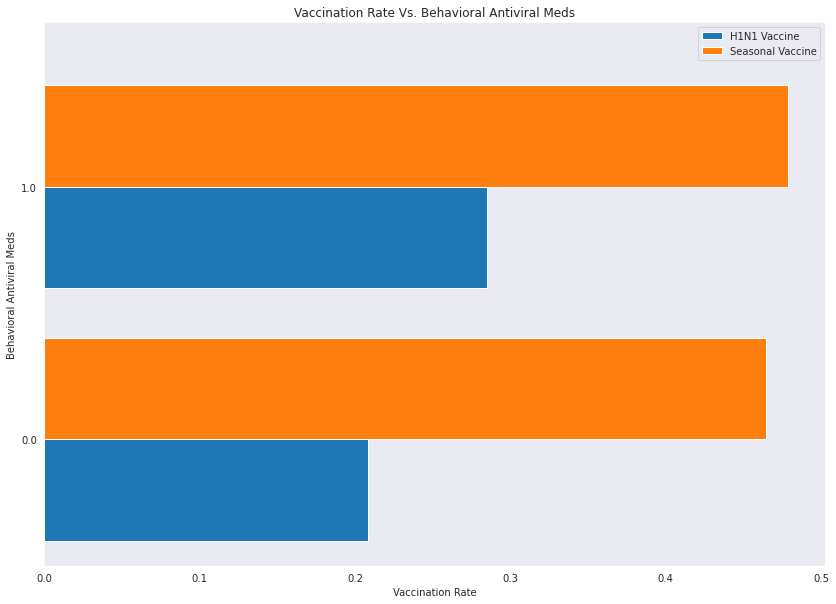

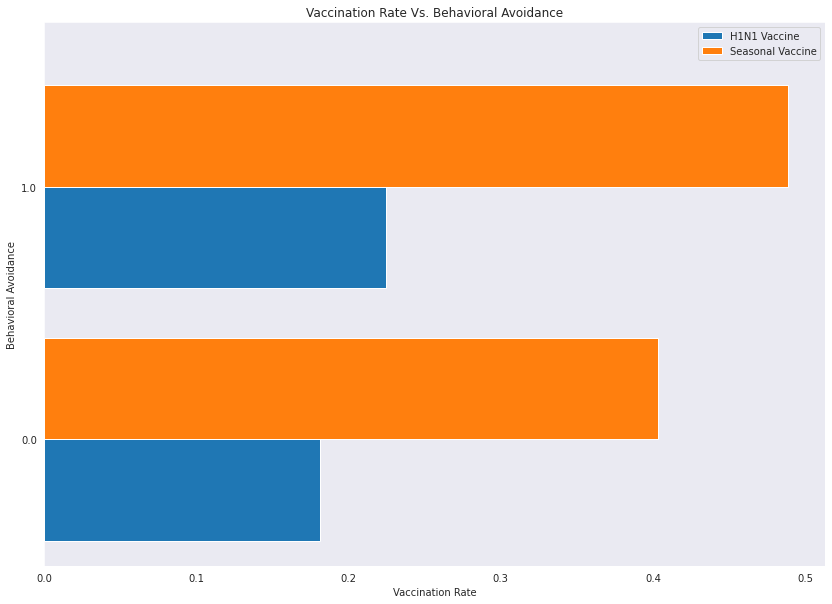

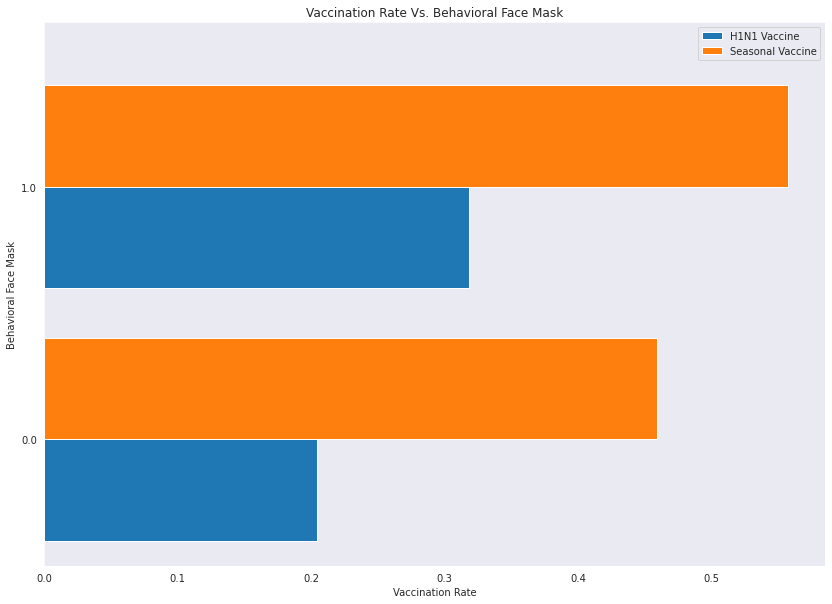

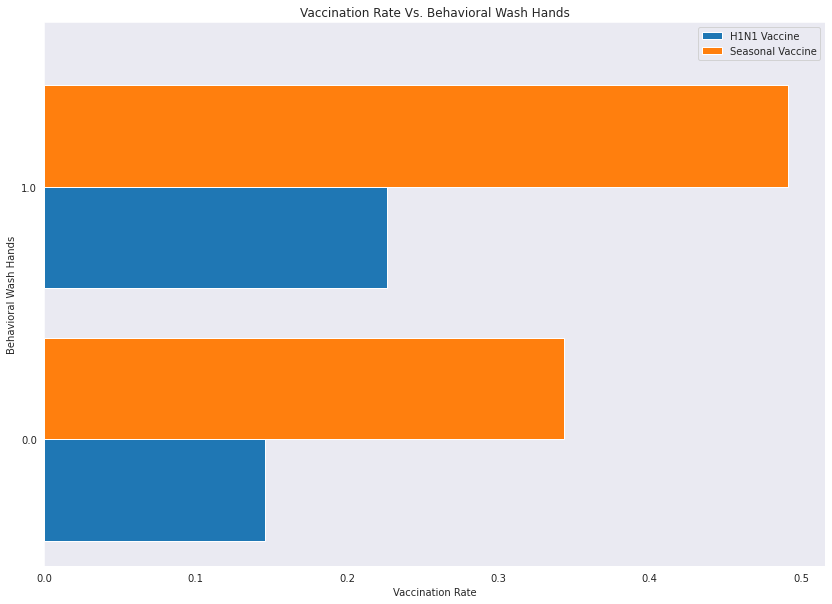

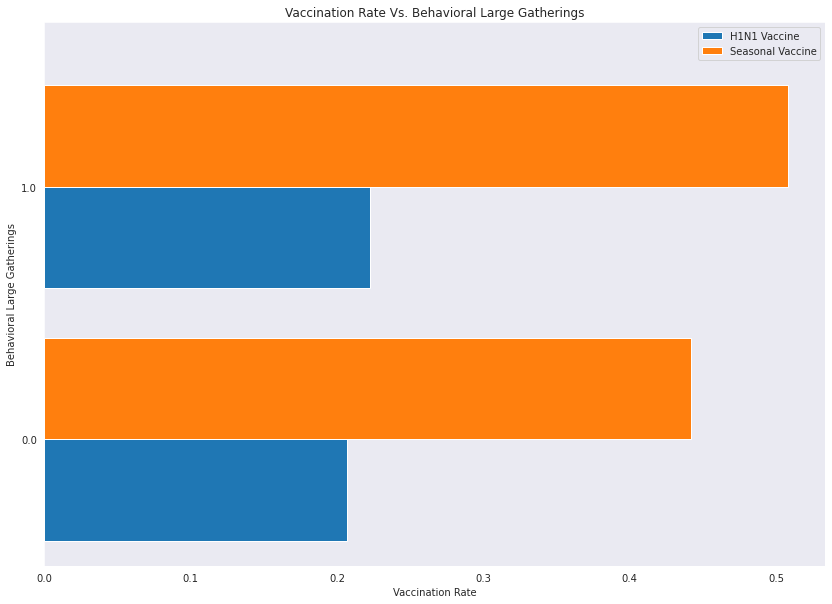

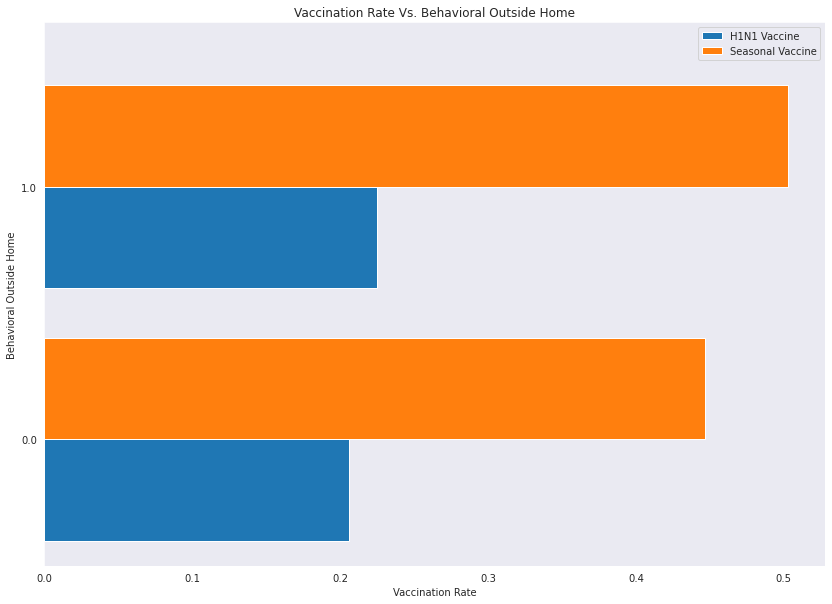

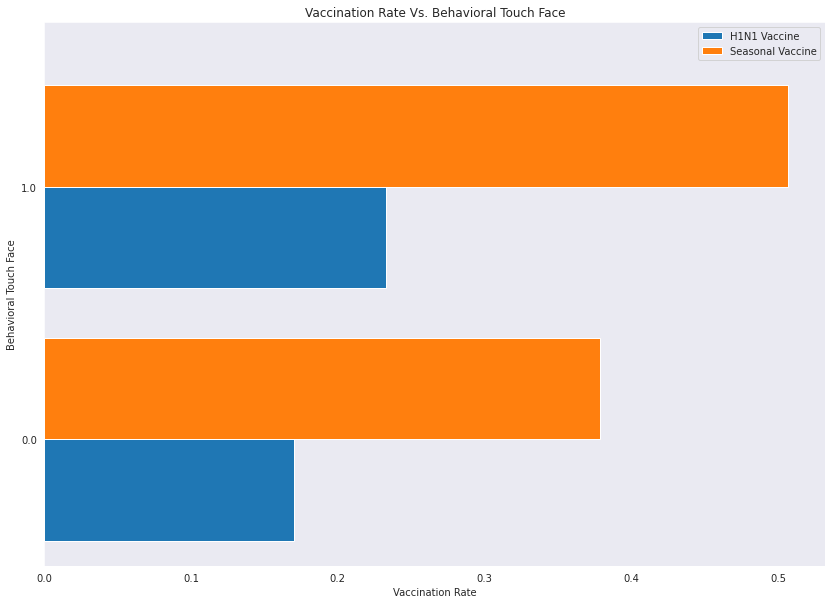

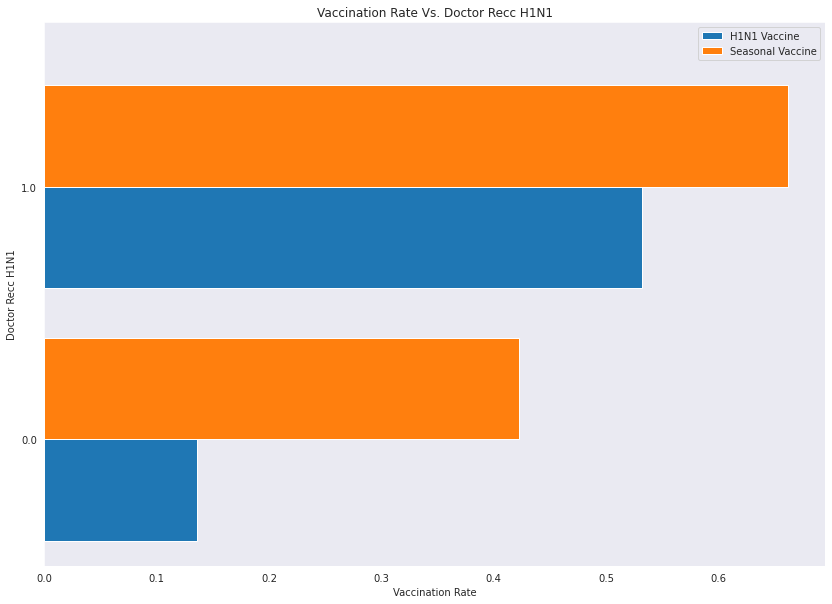

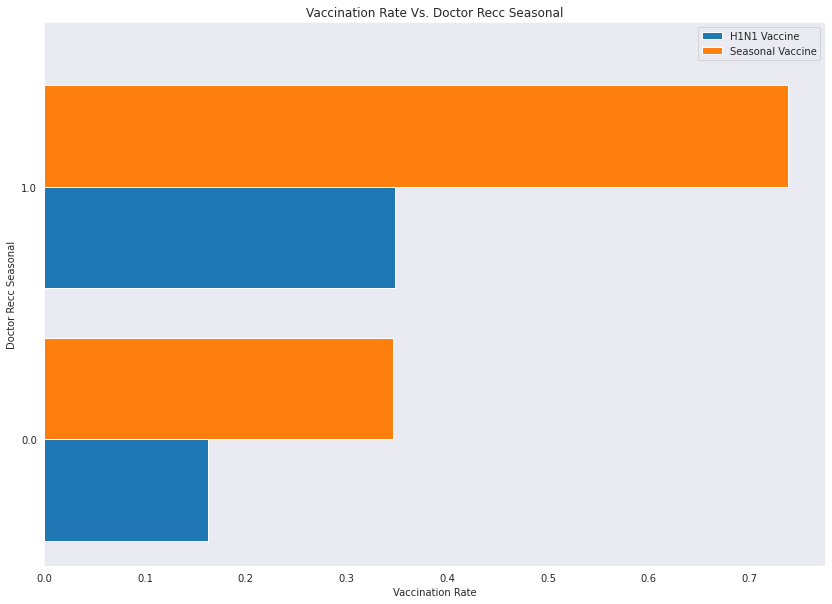

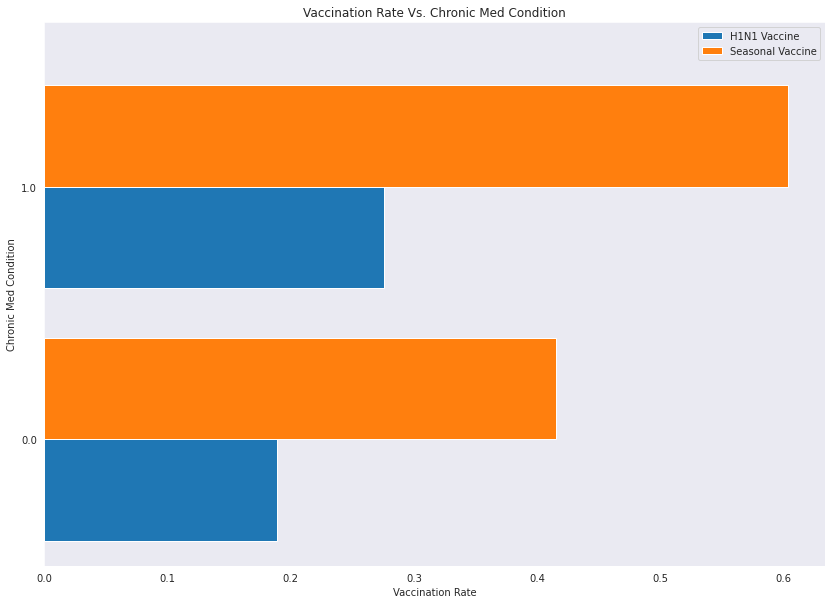

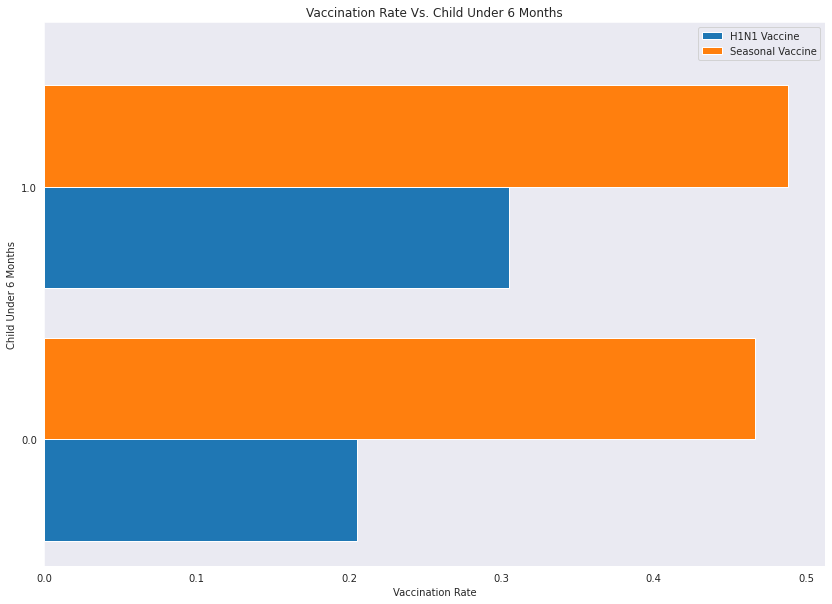

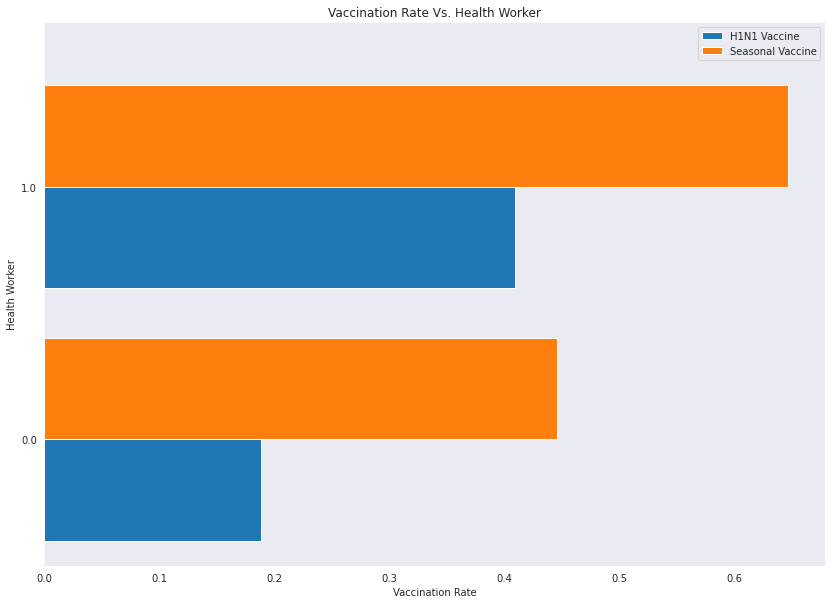

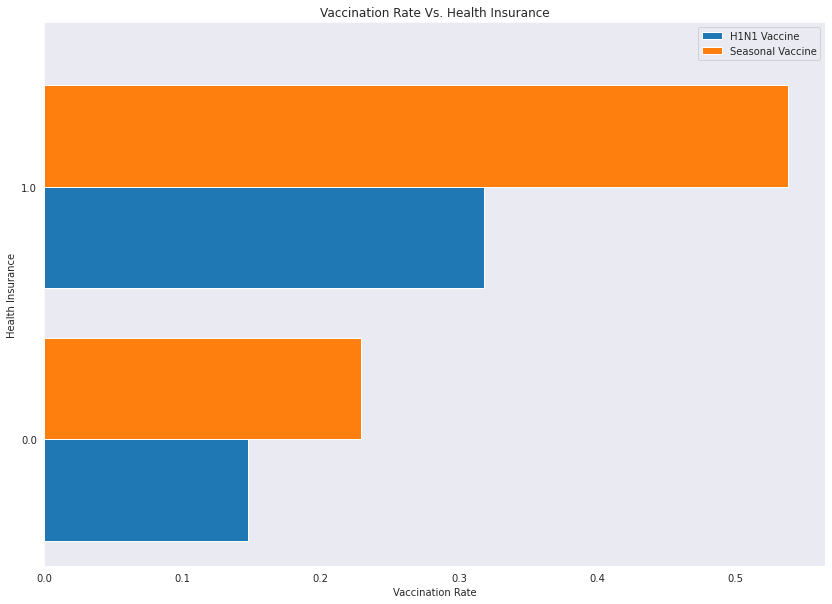

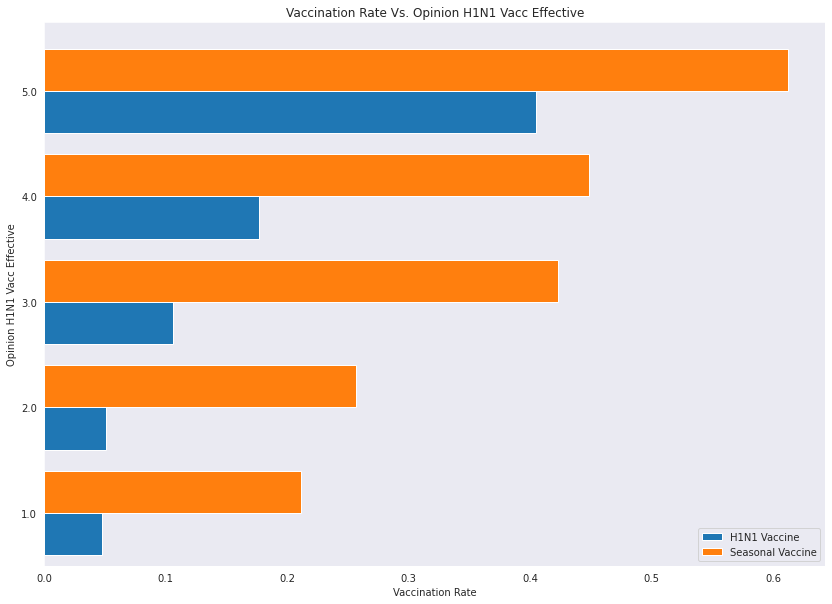

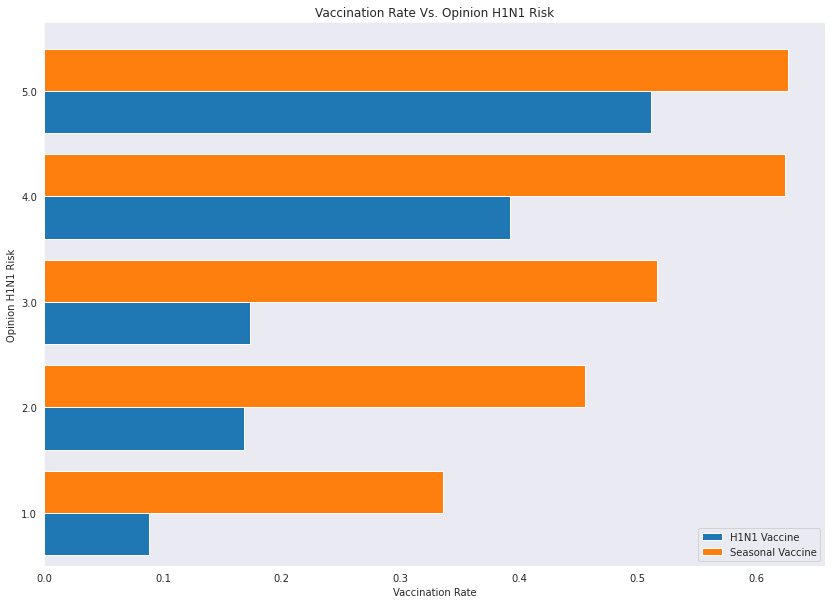

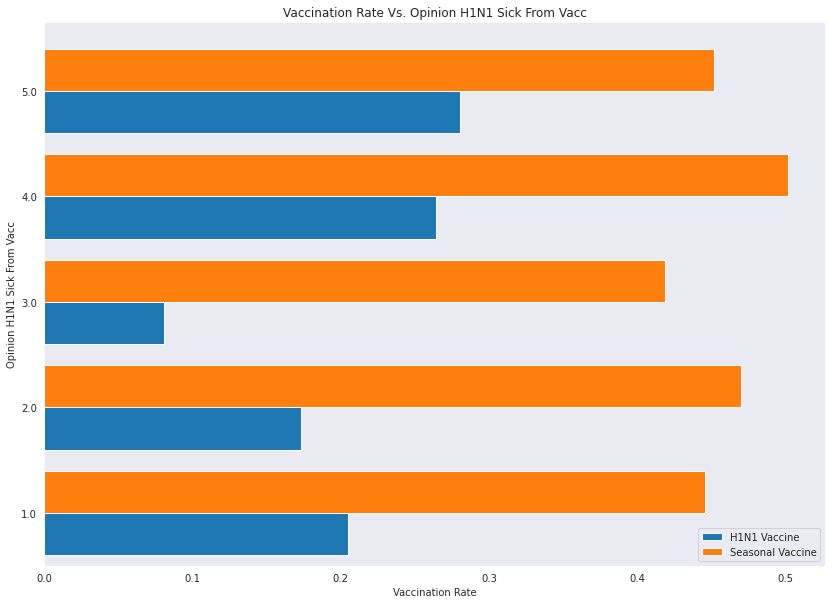

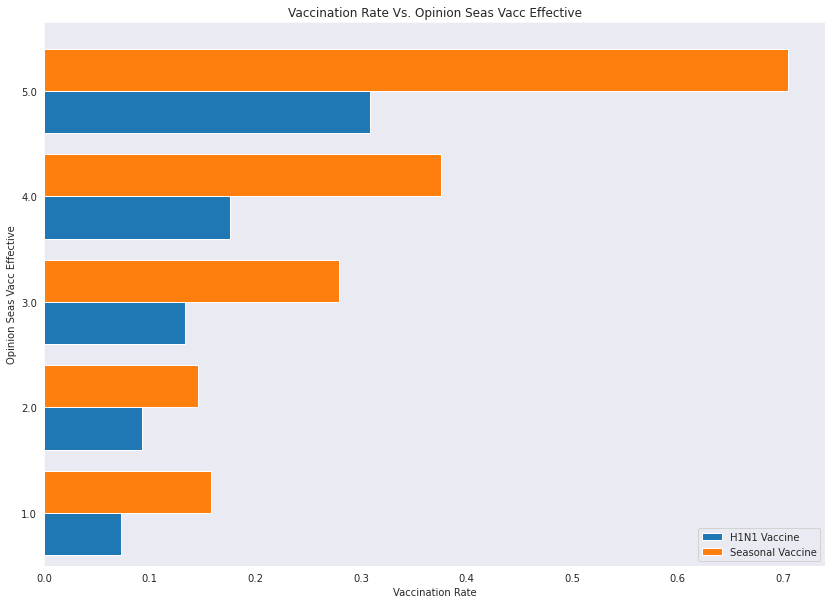

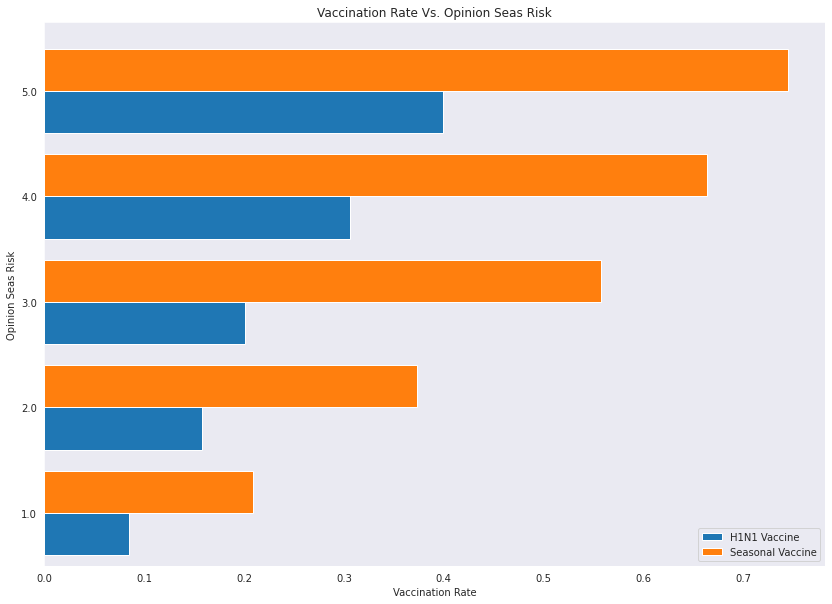

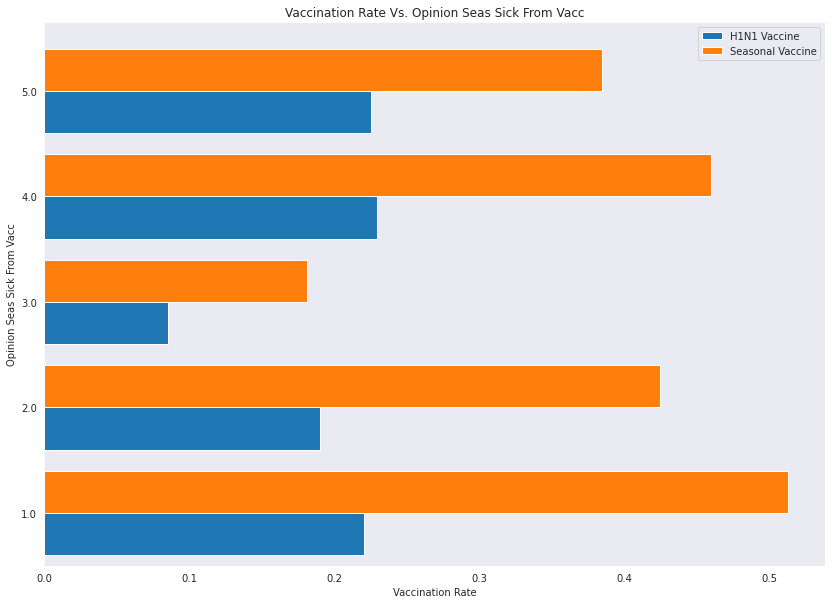

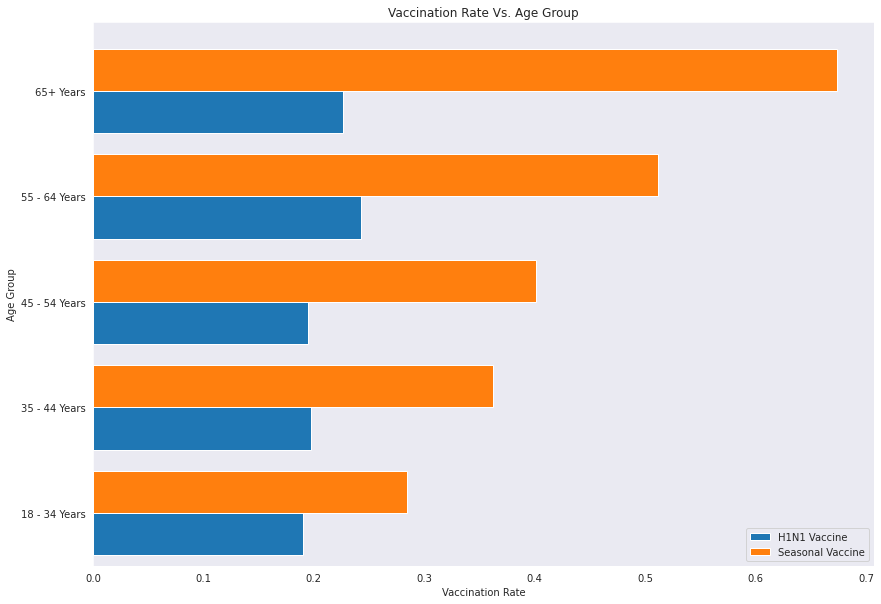

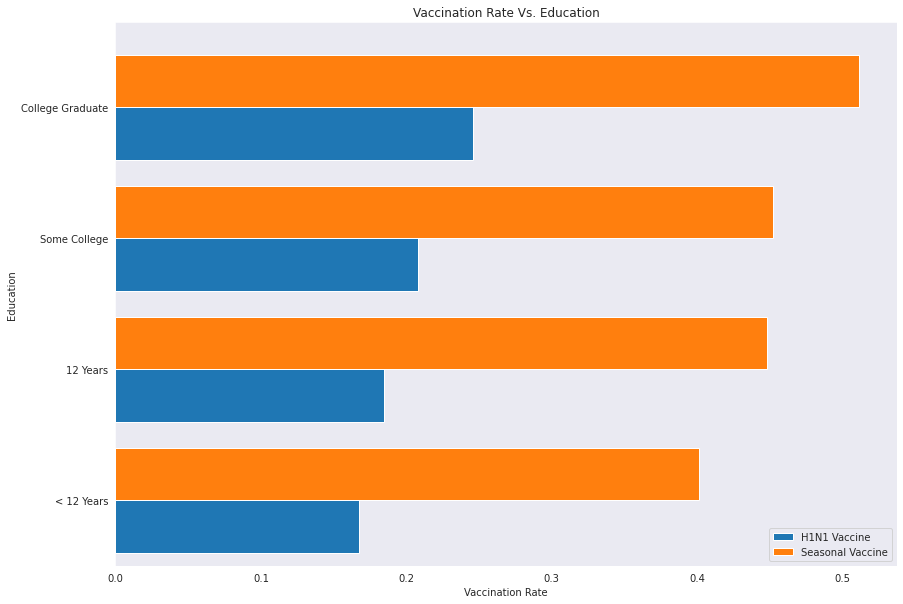

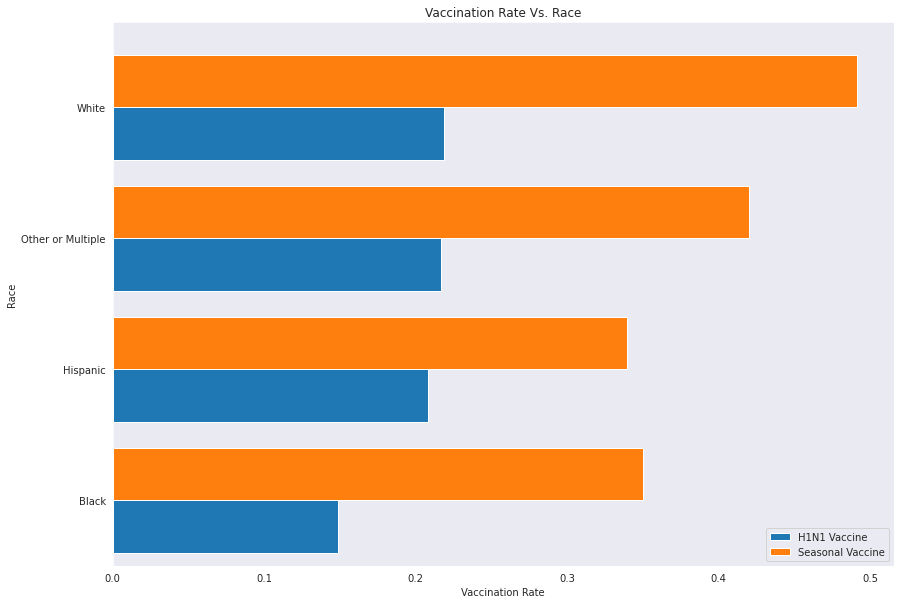

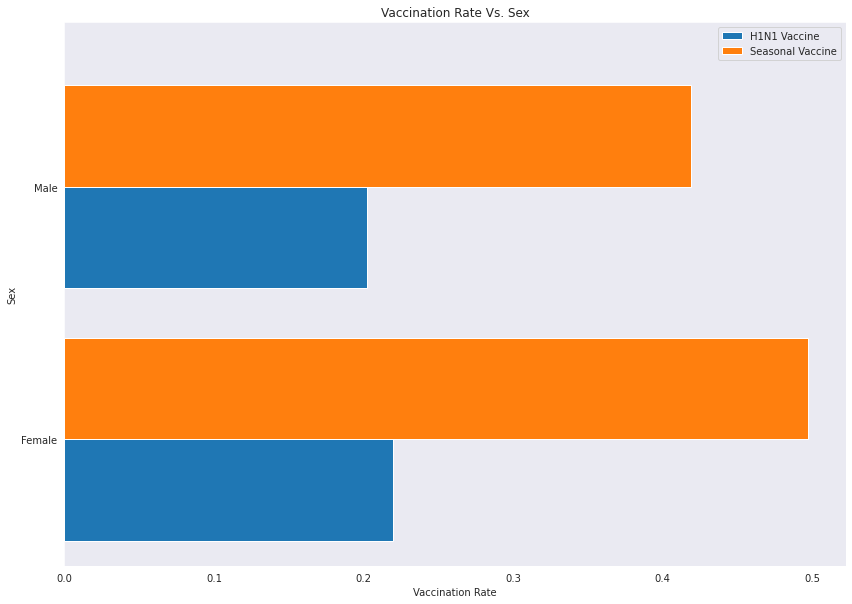

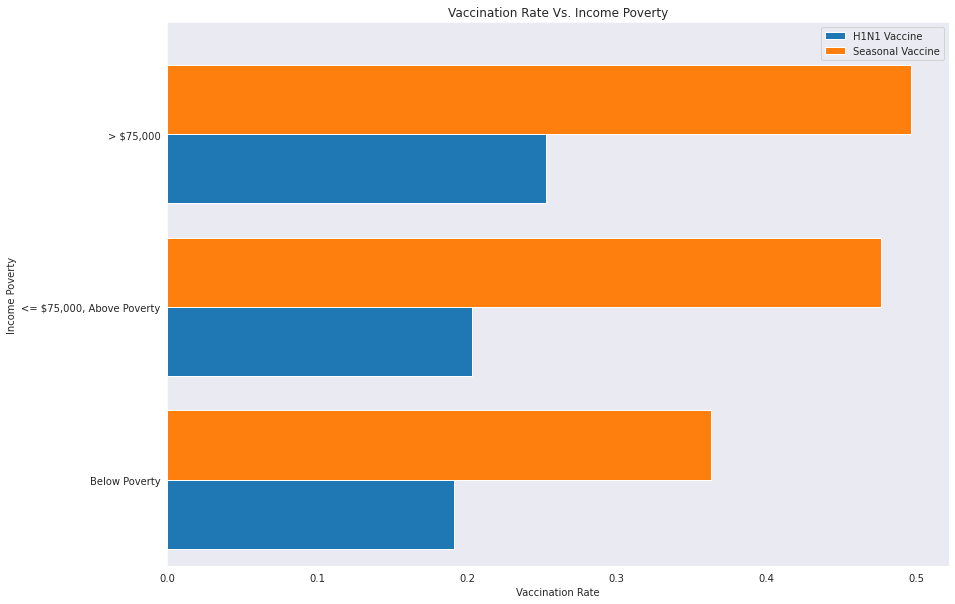

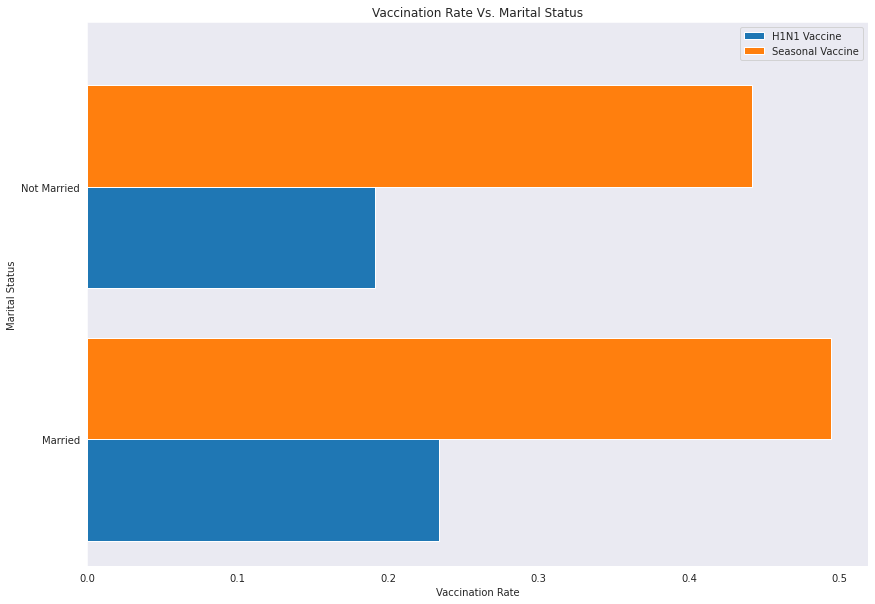

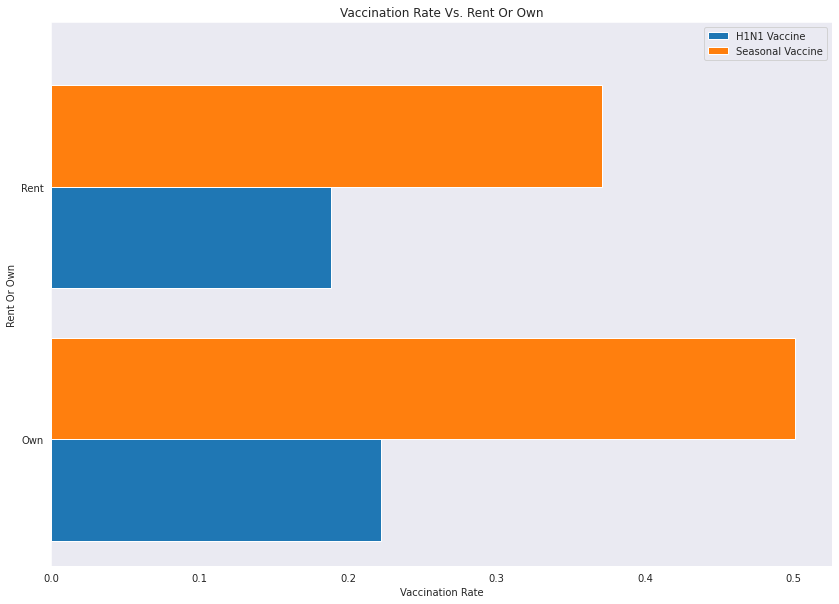

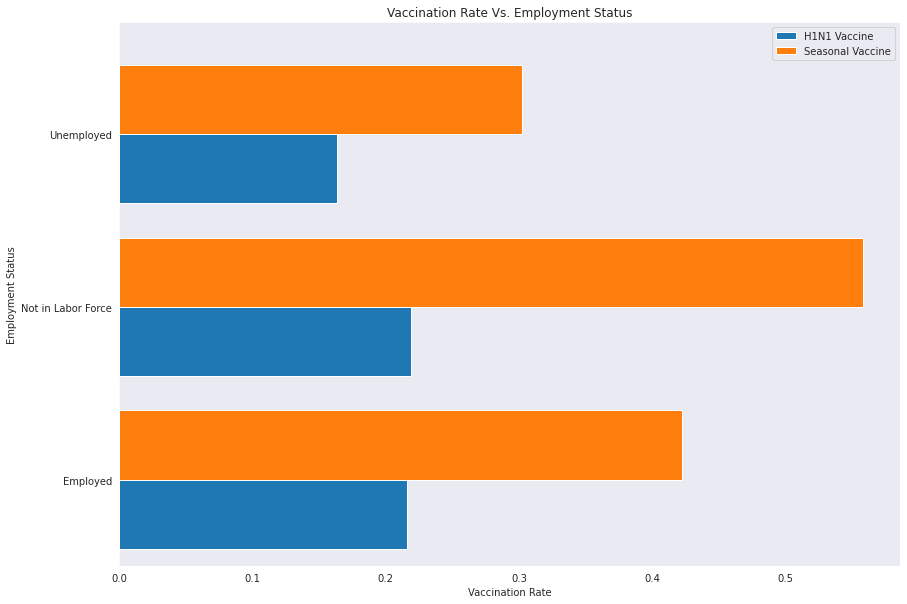

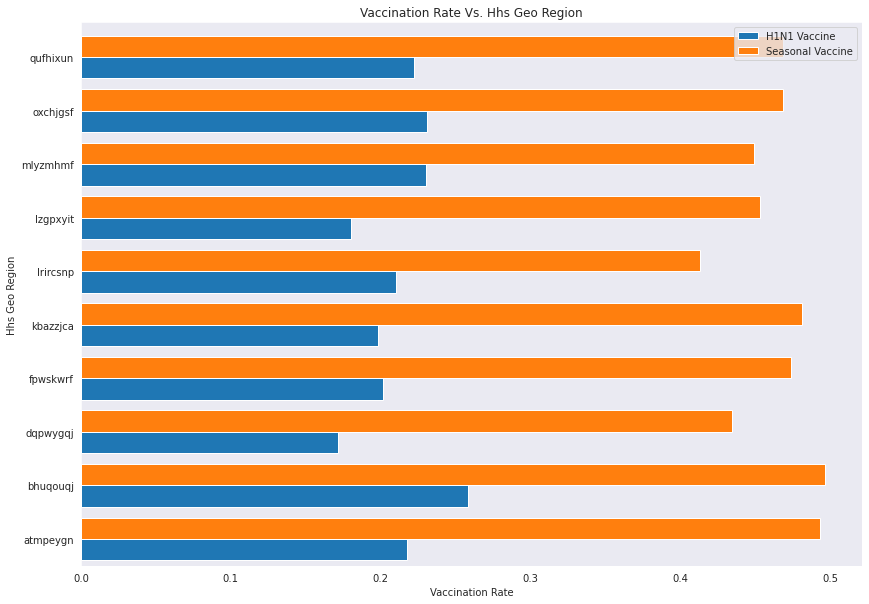

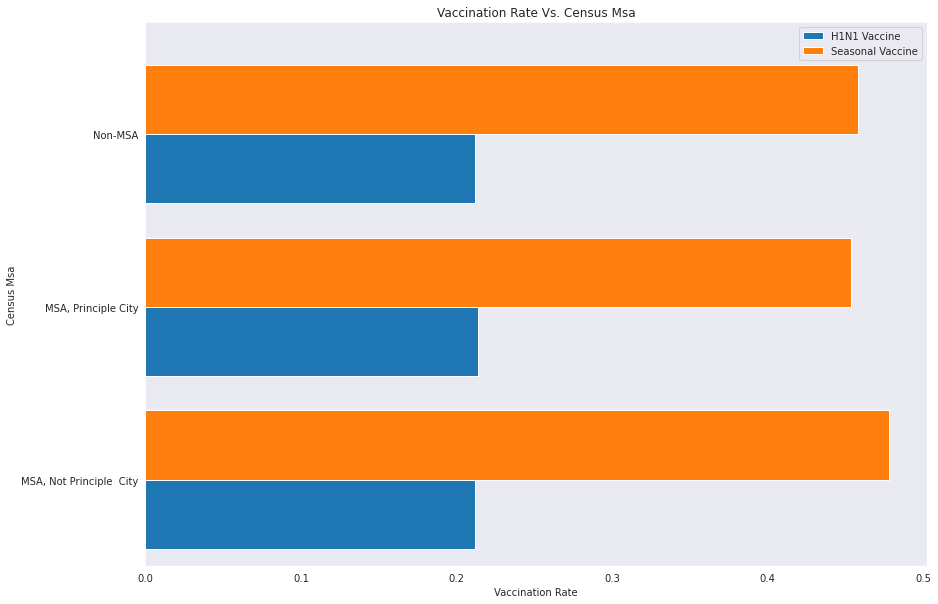

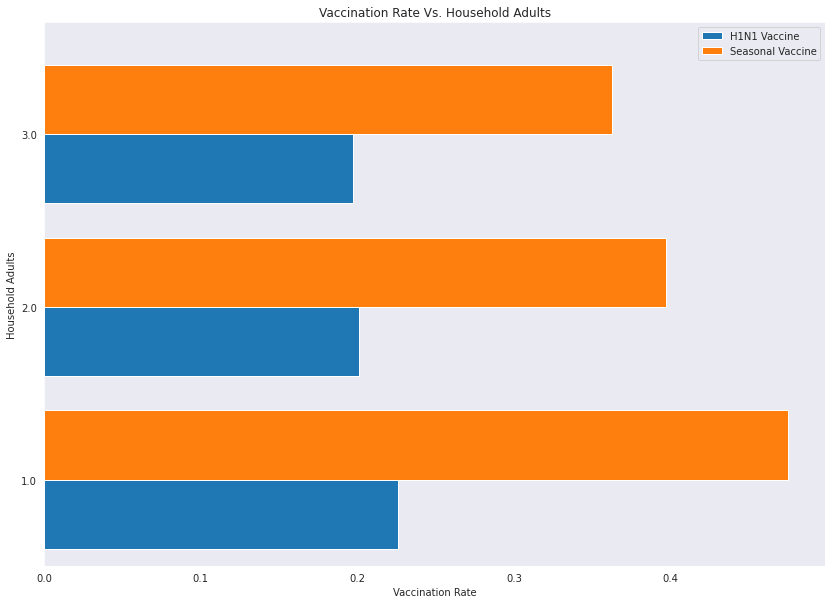

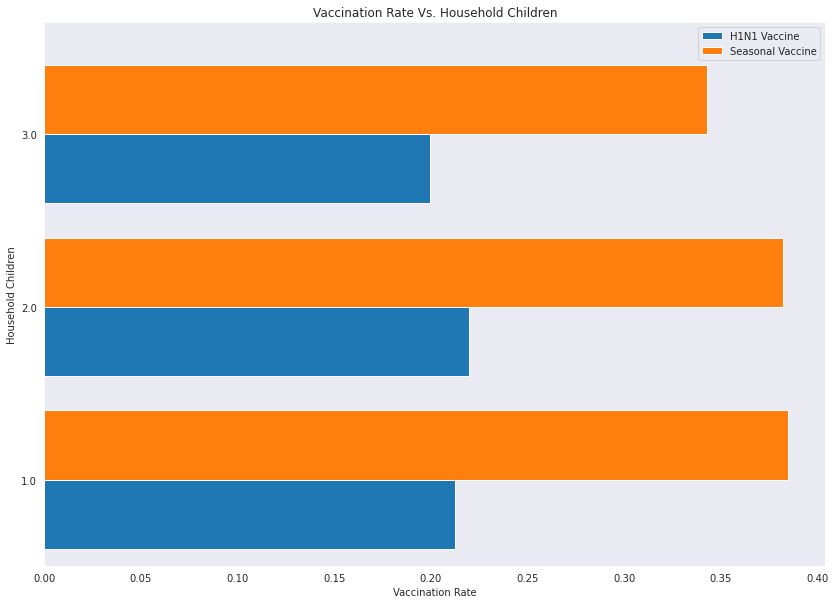

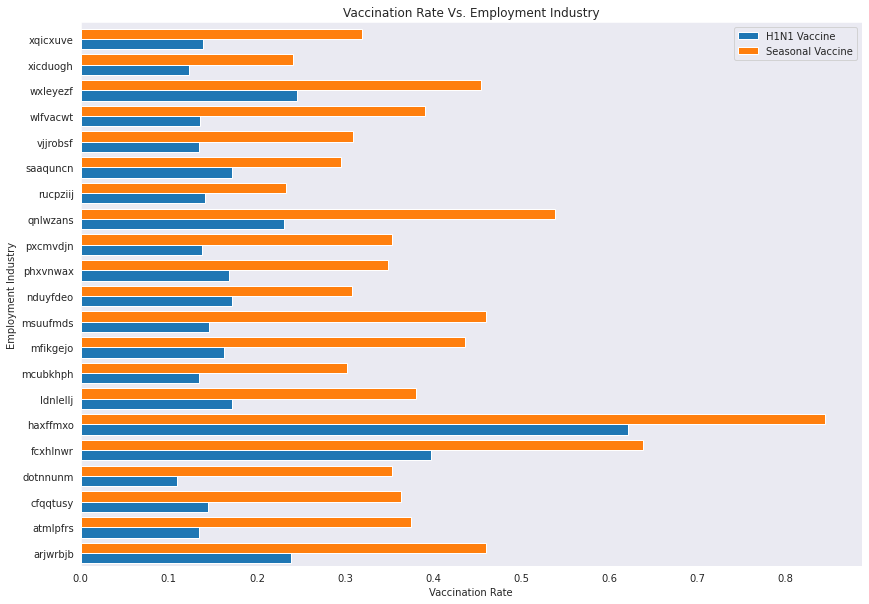

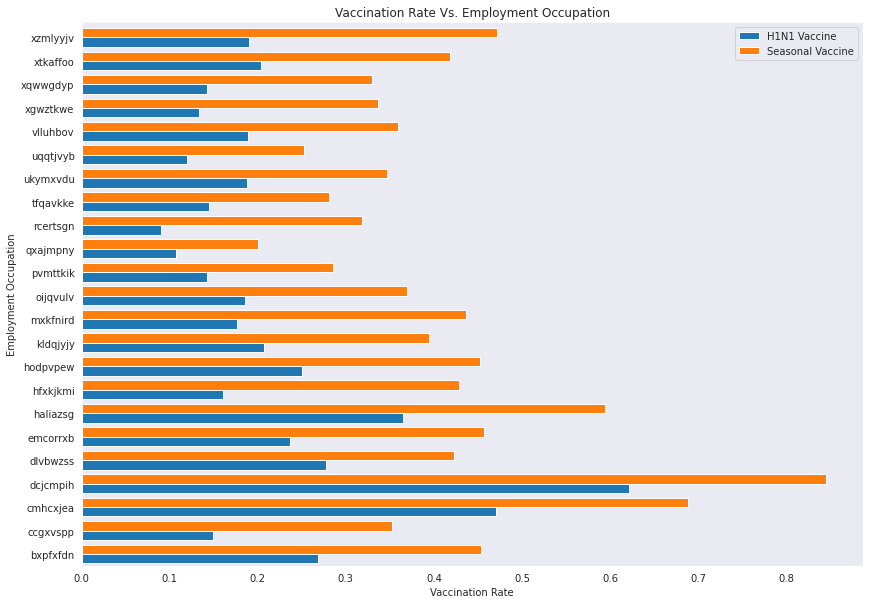

In [11]:
# Plot the vaccination rate vs. each of the features
for col in X.columns:    
    df = flushot_df[[col, 'h1n1_vaccine', 'seasonal_vaccine']].groupby(col).mean()
    fig = plt.figure(figsize=(14,10))
    ax = fig.subplots(1)
    df['h1n1_vaccine'].plot(kind='barh', ax=ax, position=1, width=0.4, color='tab:blue', label='H1N1 Vaccine')
    df['seasonal_vaccine'].plot(kind='barh', ax=ax, position=0, width=0.4, color='tab:orange', label='Seasonal Vaccine')
    ax.set_ylim(-0.5, ax.get_ylim()[-1])
    col_nice = col.title().replace('_', ' ')
    ax.set_ylabel(col_nice)
    ax.set_xlabel('Vaccination Rate')
    ax.set_title('Vaccination Rate Vs. ' + col_nice)
    ax.legend()
    plt.show()

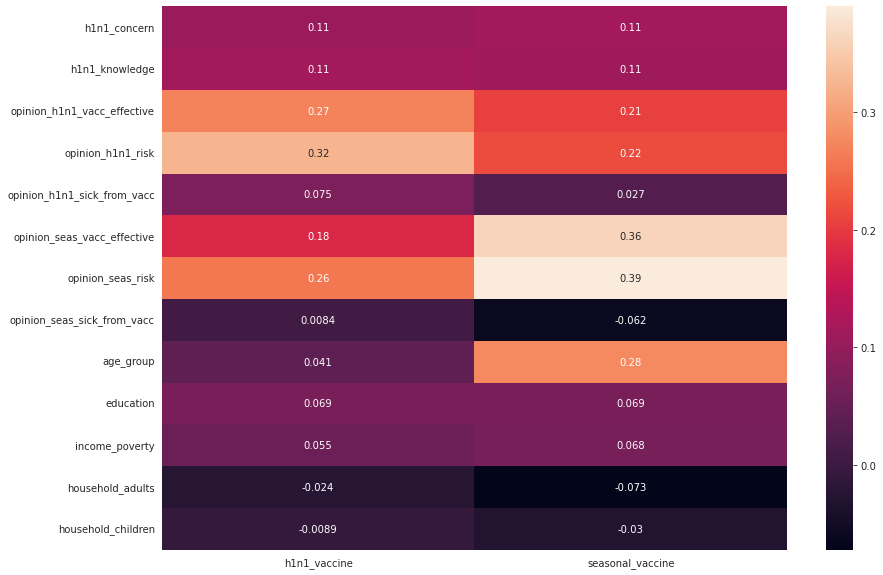

In [12]:
# Calculate the correlation coefficient between each ordinal feature and the two targets
from scipy.stats import pointbiserialr
ordinals = [col for col in X.columns if X[col].cat.ordered]
nominals = [col for col in X.columns if col not in ordinals]
corr_df = pd.DataFrame(
    {col2: [pointbiserialr(Y.loc[X[col1].notna(), col2], X.loc[X[col1].notna(), col1].cat.codes)[0] 
            for col1 in ordinals] 
     for col2 in Y.columns},
    index=ordinals)
plt.figure(figsize=(14,10))
sns.heatmap(corr_df, annot=True)
plt.show()

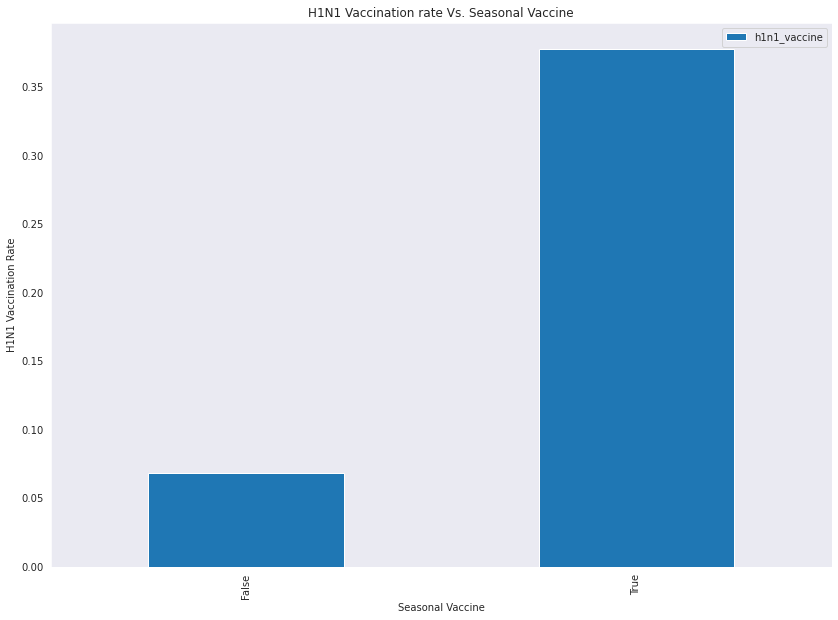

In [13]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(1)
Y.groupby('seasonal_vaccine').mean().plot(kind='bar', ax=ax)
ax.set_title('H1N1 Vaccination rate Vs. Seasonal Vaccine')
ax.set_xlabel('Seasonal Vaccine')
ax.set_ylabel('H1N1 Vaccination Rate')
plt.show()

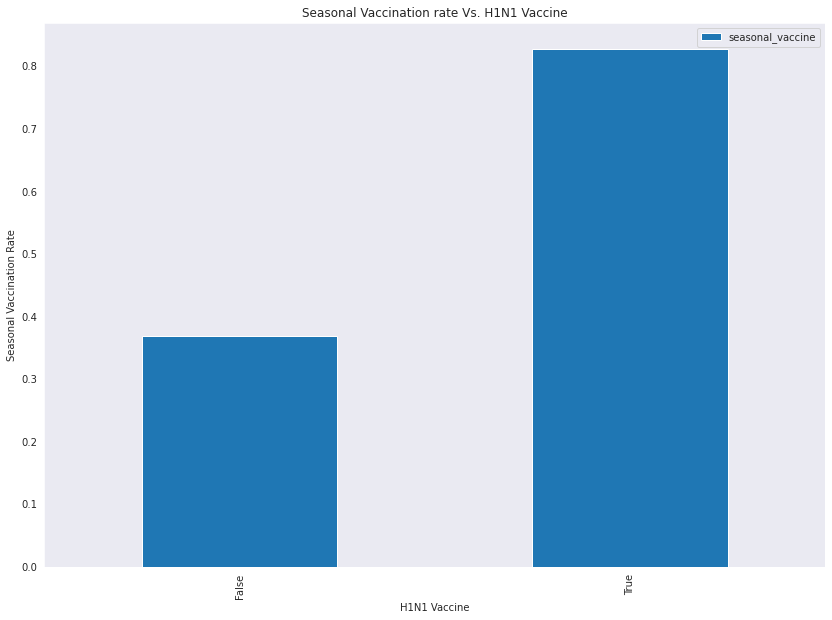

In [14]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(1)
Y.groupby('h1n1_vaccine').mean().plot(kind='bar', ax=ax)
ax.set_title('Seasonal Vaccination rate Vs. H1N1 Vaccine')
ax.set_xlabel('H1N1 Vaccine')
ax.set_ylabel('Seasonal Vaccination Rate')
plt.show()

### Observations:
1. Looking at the calculated correlations, we find that the features that are the most strongly correlated with whether one receives a vaccine or not are `opinion_seas_vacc_effective`, `opinion_seas_risk`, `opinion_h1n1_vacc_effective` and `opinion_h1n1_risk`. In other words, people's personal opinion about whether they are at risk or whether the vaccine works determines to certain degree whether they receive the vaccine or not.  Of course, this can also be interpreted the other way around, people that receive the vaccine form a positive opinion about it through their experiences.
2. Age is also an important predictor for the seasonal vaccine but not for the H1N1 vaccine.
3. Other important features, that can be qualitatively asserted from the plots above are whether a person has health insurance, whether they are a health worker and whether their doctor had recommended them to be vaccinated
4. There seems to be high correlation between the two target labels (`h1n1_vaccine`and `seasonal_vaccine`)

In [15]:
# Encode categorical variables
# Use one-hot encoding for nominals and ordinal encoding for the rest
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

col_transformer = make_column_transformer(
    (OneHotEncoder(), nominals),
    (make_pipeline(OrdinalEncoder(), StandardScaler(), SimpleImputer(strategy='median', add_indicator=True)), ordinals))

col_transformer

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1',
                                  'doctor_recc_seasonal',
                                  'chronic_med_condition',
                                  'child_under_6_months', 'health_worker',
                                  '...
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                       

# Decision Tree

We use a decision tree to predict each of the two labels.  We predict `seasonal_vaccine` and `h1n1_vaccine` sequentially taking advantage of the possible correlation between the two columns.  We test the accuracy of the model using a reserved subset of the data on which the model has not been trained.

In [16]:
# Separate data into training and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=123)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), DecisionTreeClassifier()))

tree_pipe = make_pipeline(col_transformer, chain)

In [18]:
# Find optimal parameters for the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'classifierchain__base_estimator__decisiontreeclassifier__max_depth': list(range(1, 11)),
    'classifierchain__base_estimator__decisiontreeclassifier__ccp_alpha': [0, 0.01, 0.1, 1, 10],
    'classifierchain__order': [[0, 1], [1, 0]]
}

tree_grid = RandomizedSearchCV(tree_pipe, params, scoring='roc_auc', n_iter=150, verbose=1, n_jobs=4)

tree_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_fac

In [19]:
# Best parameters
display(tree_grid.best_params_)

{'classifierchain__order': [1, 0],
 'classifierchain__base_estimator__selectpercentile__percentile': 20,
 'classifierchain__base_estimator__decisiontreeclassifier__max_depth': 6,
 'classifierchain__base_estimator__decisiontreeclassifier__criterion': 'entropy',
 'classifierchain__base_estimator__decisiontreeclassifier__ccp_alpha': 0}

In [20]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(tree_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(tree_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8395
Best model out-of-sample score: 0.8306


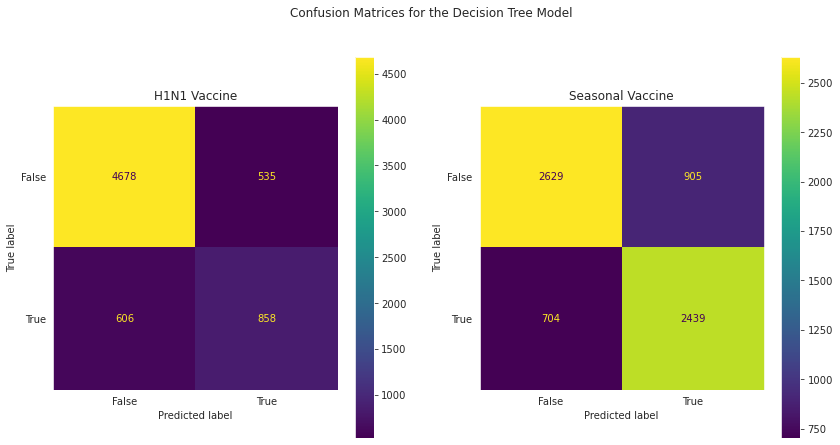

In [21]:
# Display confusion matrices for the model
from sklearn.metrics import ConfusionMatrixDisplay

predictions = tree_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Decision Tree Model')
plt.show()

In [22]:
# Prepare competition submission

best_model = tree_grid.best_estimator_
best_model.fit(X, Y)

X_comp,  = get_data('data/test_set_features.csv')

comp_predictions = pd.DataFrame(best_model.predict_proba(X_comp), index=X_comp.index, columns=Y.columns)

comp_predictions.to_csv('submissions/decision_tree.csv')

# Random Forest

We use a random forest to predict each of the two labels.  We predict `seasonal_vaccine` and `h1n1_vaccine` sequentially taking advantage of the possible correlation between the two columns.  We test the accuracy of the model using a reserved subset of the data on which the model has not been trained.

In [25]:
from sklearn.ensemble import RandomForestClassifier

chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), RandomForestClassifier()))

forest_pipe = make_pipeline(col_transformer, chain)

In [26]:
# Find best parameters for the model
params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__randomforestclassifier__n_estimators': list(range(100, 600, 100)),
    'classifierchain__base_estimator__randomforestclassifier__criterion': ['gini', 'entropy'],
    'classifierchain__base_estimator__randomforestclassifier__max_depth': list(range(5, 16)),
    'classifierchain__base_estimator__randomforestclassifier__bootstrap': [True, False],
    'classifierchain__order': [[0, 1], [1, 0]]
}

forest_grid = RandomizedSearchCV(forest_pipe, params, scoring='roc_auc', n_iter=150, verbose=1, n_jobs=4)

X_train_gr = X_train.sample(frac=0.1)
Y_train_gr = Y_train.loc[X_train_gr.index]

forest_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_fac

In [27]:
# Best parameters for the model
display(forest_grid.best_params_)

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__selectpercentile__percentile': 50,
 'classifierchain__base_estimator__randomforestclassifier__n_estimators': 200,
 'classifierchain__base_estimator__randomforestclassifier__max_depth': 12,
 'classifierchain__base_estimator__randomforestclassifier__criterion': 'entropy',
 'classifierchain__base_estimator__randomforestclassifier__bootstrap': False}

In [28]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(forest_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(forest_grid.score(X_test, Y_test)))

Best model in-sample score: 0.9418
Best model out-of-sample score: 0.8581


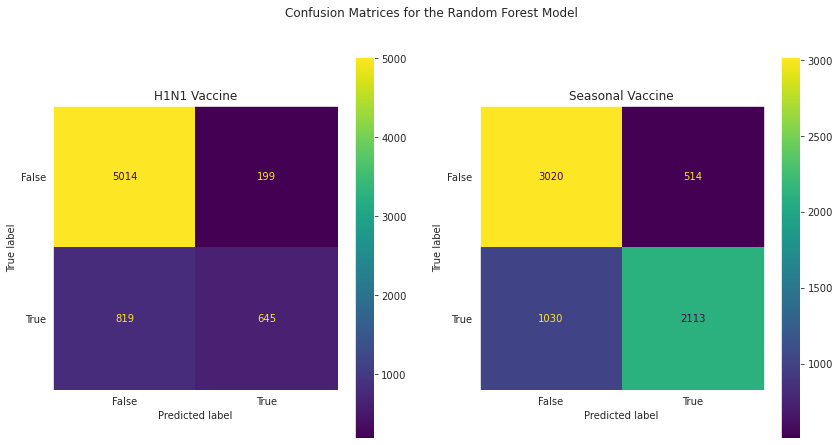

In [29]:
# Display confusion matrices for the model

predictions = forest_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Random Forest Model')
plt.show()

In [30]:
# Prepare competition submission

best_model = forest_grid.best_estimator_
best_model.fit(X, Y)

comp_predictions = pd.DataFrame(best_model.predict_proba(X_comp), index=X_comp.index, columns=Y.columns)

comp_predictions.to_csv('submissions/random_forest.csv')

# k-Nearest Neighbors

We use a k-Nearest-Neighbors model to predict each of the two labels.  We predict `seasonal_vaccine` and `h1n1_vaccine` sequentially taking advantage of the possible correlation between the two columns.  We test the accuracy of the model using a reserved subset of the data on which the model has not been trained.

In [32]:
from sklearn.neighbors import KNeighborsClassifier

chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), KNeighborsClassifier()))

knn_pipe = make_pipeline(col_transformer, chain)

In [33]:
# FInd best parameters for the model

params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 20, 50],
    'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': list(range(60, 160, 10)),
    'classifierchain__base_estimator__kneighborsclassifier__weights': ['uniform', 'distance'],
    'classifierchain__base_estimator__kneighborsclassifier__p': [1, 2],
    'classifierchain__order': [[0, 1], [1, 0]]
}
    
knn_gird = RandomizedSearchCV(knn_pipe, params, scoring='roc_auc', n_iter=120, verbose=1)

knn_gird.fit(X_train, Y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_fac

In [34]:
# Best parameters for the model
display(knn_gird.best_params_)

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__selectpercentile__percentile': 20,
 'classifierchain__base_estimator__kneighborsclassifier__weights': 'uniform',
 'classifierchain__base_estimator__kneighborsclassifier__p': 1,
 'classifierchain__base_estimator__kneighborsclassifier__n_neighbors': 130}

In [35]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(knn_gird.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(knn_gird.score(X_test, Y_test)))

Best model in-sample score: 0.8520
Best model out-of-sample score: 0.8447


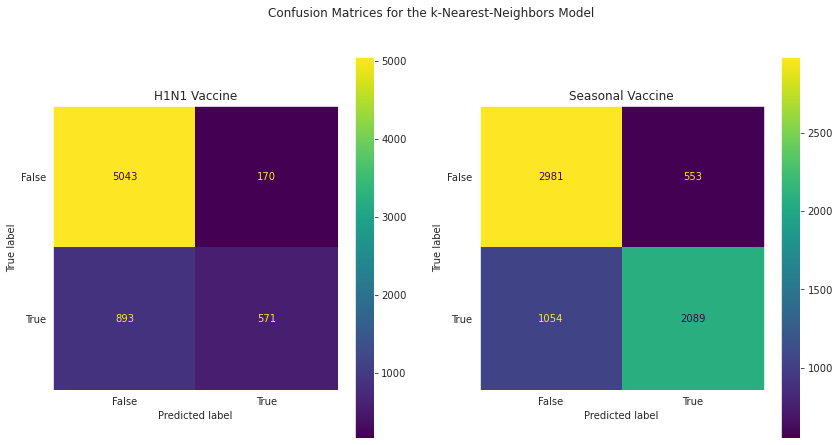

In [36]:
# Display confusion matrices for the model

predictions = knn_gird.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the k-Nearest-Neighbors Model')
plt.show()

In [37]:
# Prepare competition submission

best_model = knn_gird.best_estimator_
best_model.fit(X, Y)

comp_predictions = pd.DataFrame(best_model.predict_proba(X_comp), index=X_comp.index, columns=Y.columns)

comp_predictions.to_csv('submissions/knn.csv')

# Gradient-boosted decision tree

We use a gradient-boosted decision tree to predict each of the two labels.  We predict `seasonal_vaccine` and `h1n1_vaccine` sequentially taking advantage of the possible correlation between the two columns.  We test the accuracy of the model using a reserved subset of the data on which the model has not been trained.

In [38]:
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

chain = ClassifierChain(make_pipeline(SelectPercentile(mutual_info_classif), 
                                      XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=1)))

xgb_pipe = make_pipeline(col_transformer, chain)

/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [44]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'classifierchain__base_estimator__selectpercentile__percentile': [10, 50, 90],
    'classifierchain__base_estimator__xgbclassifier__n_estimators': [100, 200, 500],
    'classifierchain__base_estimator__xgbclassifier__max_depth': list(range(1, 6)),
    'classifierchain__base_estimator__xgbclassifier__learning_rate': [0.1, 0.2],
    'classifierchain__base_estimator__xgbclassifier__reg_lambda': [0.1, 0.2, 0.3],
    'classifierchain__order': [[0, 1], [1, 0]]
}

xgb_grid = RandomizedSearchCV(xgb_pipe, params, scoring='roc_auc', n_iter=270, verbose=1, n_jobs=4)

xgb_grid.fit(X_train, Y_train.astype(int))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/mhadjian/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be re

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['behavioral_antiviral_meds',
                                                                                'behavioral_avoidance',
                                                                                'behavioral_face_mask',
                                                                                'behavioral_wash_hands',
                                                                                'behavioral_large_gatherings',
                                                                                'behavioral_outside_home',
                                                                                'behavioral_touch_fac

In [45]:
# Best parameters for the model
display(xgb_grid.best_params_)

{'classifierchain__order': [0, 1],
 'classifierchain__base_estimator__xgbclassifier__reg_lambda': 0.1,
 'classifierchain__base_estimator__xgbclassifier__n_estimators': 200,
 'classifierchain__base_estimator__xgbclassifier__max_depth': 3,
 'classifierchain__base_estimator__xgbclassifier__learning_rate': 0.1,
 'classifierchain__base_estimator__selectpercentile__percentile': 90}

In [46]:
# Score for best model, using test data
print('Best model in-sample score: {:.4f}'.format(xgb_grid.score(X_train, Y_train)))
print('Best model out-of-sample score: {:.4f}'.format(xgb_grid.score(X_test, Y_test)))

Best model in-sample score: 0.8810
Best model out-of-sample score: 0.8637


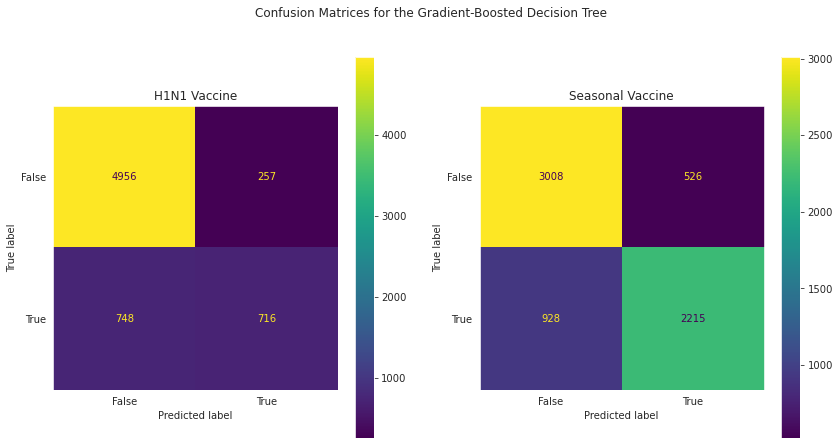

In [47]:
# Display confusion matrices for the model

from sklearn.metrics import ConfusionMatrixDisplay

predictions = xgb_grid.predict(X_test)

fig = plt.figure(figsize=(14, 7))
axs = fig.subplots(1, 2)
for i, col in enumerate(Y_test.columns):
    ConfusionMatrixDisplay.from_predictions(Y_test[col], predictions[:, i], ax=axs[i])
    axs[i].set_title(col.title().replace('_', ' '))
fig.suptitle('Confusion Matrices for the Gradient-Boosted Decision Tree')
plt.show()

In [48]:
# Prepare competition submission

best_model = xgb_grid.best_estimator_
best_model.fit(X, Y)

X_comp,  = get_data('data/test_set_features.csv')

comp_predictions = pd.DataFrame(best_model.predict_proba(X_comp), index=X_comp.index, columns=Y.columns)

comp_predictions.to_csv('submissions/xgboost.csv')

_Comment on feature selection:_

Some of the  models like, like the decision tree and k-Nearest Neighbors benefit from selecting a smaller subset of features.  On the other hand, there is no significant improvement for the gradient-boosted decision tree.